# Example of using `infant_tools` to count transitions between touched locations.
content:
+ loading all data in database as `data_dict`
+ computation of frequencies of transitions between touched locations
+ plotting frequency matrix
+ plotting frequency matrix on body scheme 
+ weighted directed graph representation of frequency matrix
+ network density example
+ average density for weeks, plot values with standard error of mean 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import infant_tools.load_data as load_data
import infant_tools.timeseries as timeseries
import infant_tools.transitions as transitions
import infant_tools.plotting as plotting

%matplotlib inline
# !! after changing infant_tools resources kernel need to be restarted !! 

## Define constant parameters

In [2]:
# format of time series data
NO_TOUCH = "NONE"
HELP = "HELP"
RH = "RH"
LH = "LH"
INFANTS = ["AA", "TH", "CA", "RT"]

# paths to data
framerate_path = "/home/jur0/LAB/main/self-touch-sequence-models/data/SELF_TOUCH_TIMESERIES/framerate.csv"
data_path = "/home/jur0/LAB/main/self-touch-sequence-models/data/SELF_TOUCH_TIMESERIES"

body_scheme_path = "/home/jur0/LAB/main/self-touch-sequence-models/data/visualization_data/scheme.png"
coordinates_path = "/home/jur0/LAB/main/self-touch-sequence-models/data/visualization_data/coordinates.csv"
 


# definition of touched areas
# without "back" labels
LOCATIONS = ['1L', '1R','2L', '2R','3L','3R', '4L', '4R', '5L', '5R','6L', '6R', '7L', '7R', '8L',
 '8R','9L','9R','10L','10R','11L','11R','13L','13R','16L','16R','17L','17R']

# older recordings were coded with higher spatial resolution, therefore we need to define how to merge these areas  
LOCATIONS_SIMPLIFICATION = {"13L": ["13L", "15L"], "13R": ["13R", "15R"], "11L":["11L", "12L", "14L"], "11R":["11R", "12R", "14R"]}

## Load data

In [3]:
data_dict, filename_dict = load_data.get_all_data(data_path)

## count transitions frequencies 

for working with transitions between touched locations, class `Transitions` from _transitions.py_ is used. 
To compute the frequencies of transitions between touched areas, its function `count_transitions_in_range` was implemented. One of its input parameters is a time interval which defines the duration of 'no touching' state. If the duration of 'no touching' state between touched areas is within this interval, the transition is counted.  

The result is a frequency matrix (squared matrix with size equal to number of areas / LOCATIONS), where each row represents previously touched area, column represents next touched area and values are the counts of corresponding transitions in recording.


define `pipeline` to process each hand separately
+ convert to `numpy.ndarray`
+ edit areas as needed 
+ split data into parts based on `HELP` during recording 
+ count transitions frequency matrix for each part of time series and sum them together

In [4]:
def pipeline(data, filename, hand, no_touch_range):
    # data is the loaded time series as pandas.DataFrame (values of data_dict)
    size = len(LOCATIONS)
    # convert to numpy
    tm = data[hand].to_numpy()
    # in this example convert all 'back' areas to front areas
    tm = timeseries.back2normal(tm)
    # merge locations as needed
    tm = timeseries.merge_locations(tm, LOCATIONS_SIMPLIFICATION)
    # split time series into parts based on help
    tm_parts = timeseries.split_timeseries_by_help(tm, HELP)

    # define frequency matrix
    frequency_matrix = np.zeros((size, size))

    framerate = load_data.get_video_framerate(filename, framerate_path)
    # convert interval from seconds to frames
    no_touch_threshold_frames = [val*framerate for val in no_touch_range]
    # iterate over parts of time series
    for tm_i in tm_parts:
        # define Transitions object with NO_TOUCH included (needed for count_transitions_in_range)
        model = transitions.Transitions(LOCATIONS + [NO_TOUCH])

        _frequency_matrix = model.count_transitions_in_range(tm_i, NO_TOUCH, no_touch_threshold_frames)            
        frequency_matrix += _frequency_matrix

    # create one Transitions object from frequency_matrix in frequency_matrix of recording
    model = transitions.Transitions(LOCATIONS)
    model.frequency_matrix = frequency_matrix
    return model

apply pipeline to `data_dict`

In [5]:
# define range  (e.g., for counting only complex touches set interval to [0,0])
transitions_interval = [0, 0] # s 

frequencies_RH = load_data.apply_data_dict_function(data_dict, pipeline, RH, transitions_interval, filename_dict=filename_dict)
frequencies_LH = load_data.apply_data_dict_function(data_dict, pipeline, LH, transitions_interval, filename_dict=filename_dict)

### plot Frequency matrix for each hand 

In [6]:
# select only one recording

recording_frequencies_RH = frequencies_RH["AA"]["11w"][0]
recording_frequencies_LH = frequencies_LH["AA"]["11w"][0]

Text(0.5, 0.98, 'frequencies of transitions')

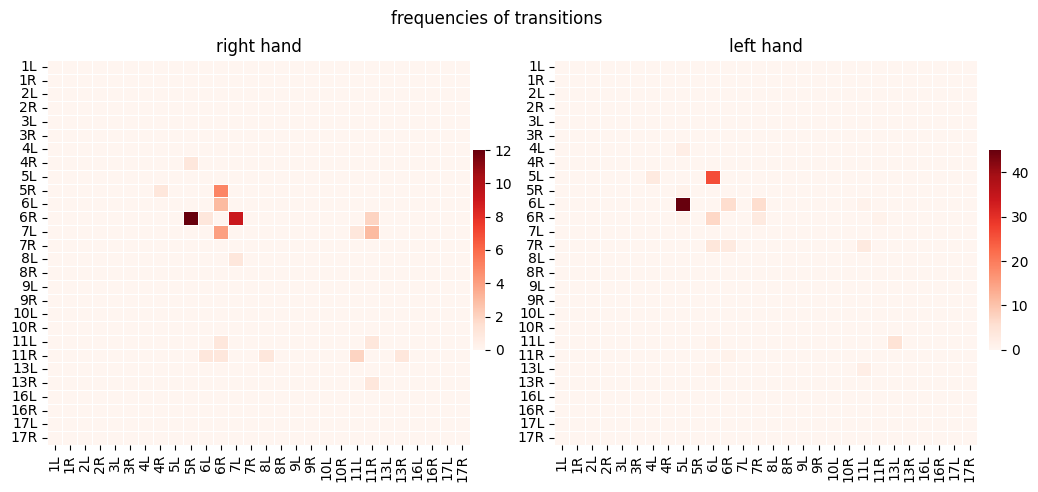

In [7]:
# plot frequencies matrix for one recording
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 5))
cbar_ax1 = fig.add_axes([.48, .3, .01, .4])
cbar_ax2 = fig.add_axes([.91, .3, .01, .4])

recording_frequencies_RH.plot(axes[0], cbar_ax=cbar_ax1)
recording_frequencies_LH.plot(axes[1], cbar_ax=cbar_ax2)

axes[0].set_title("right hand")
axes[1].set_title("left hand")
fig.suptitle("frequencies of transitions")

### plot frequency matrices on infant body scheme

In [8]:
# load for plotting : image of body scheme, coordinates for each location
coordinates = pd.read_csv(coordinates_path, sep=",")
scheme = plt.imread(body_scheme_path)
# get coordinates of labels
x = coordinates["x"]
y = coordinates["y"]
locs = coordinates["loc"]

model = transitions.Transitions(LOCATIONS)
coordinates = {model.labels_inv[k]: (x[locs == k].values[0], y[locs == k].values[0]) for k in list(model.labels_inv.keys())}


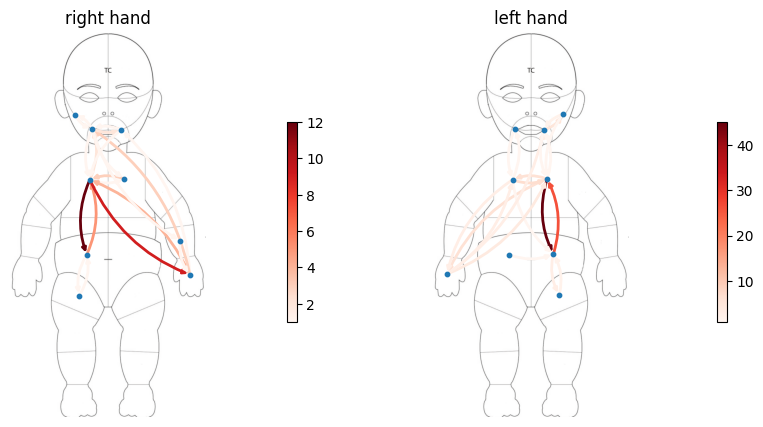

In [9]:
# create weighted directed graph representation of frequency matrix
recording_frequencies_RH.create_graph()
recording_frequencies_LH.create_graph()


fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 5))
cbar_ax1 = fig.add_axes([.48, .3, .01, .4])
cbar_ax2 = fig.add_axes([.91, .3, .01, .4])

# plot body scheme
axes[0].imshow(scheme)
axes[1].imshow(scheme)
axes[0].set_title("right hand")
axes[1].set_title("left hand")

# draw graphs on axis
recording_frequencies_RH.draw_graph(axes[0], coordinates, node_size=10, arrowsize=6, width=2, edge_cmap=plt.cm.Reds, connectionstyle="arc3,rad=0.2")
recording_frequencies_LH.draw_graph(axes[1], coordinates, node_size=10, arrowsize=6, width=2, edge_cmap=plt.cm.Reds, connectionstyle="arc3,rad=0.2")

# add colorbars
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds,
                        norm=plt.Normalize(vmin=1, vmax=np.max(recording_frequencies_RH.frequency_matrix))) # np.max(MM.transition_matrix)
cbar = fig.colorbar(sm, cax=cbar_ax1)

sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds,
                        norm=plt.Normalize(vmin=1, vmax=np.max(recording_frequencies_LH.frequency_matrix))) # np.max(MM.transition_matrix)
cbar = fig.colorbar(sm, cax=cbar_ax2)



## Other example - network density

Frequency matrices can be represented as weighted directed graphs, where weights of edges correspond to frequencies of transitions and the nodes are touched areas.
Conversion to weighted DG is implemented as a method `create_graph` of `Transitions` object (as in previous example). 
> Note that the graph / network is not created from all areas, but only from areas that were touched during the recording
The graph is created using `NetworkX` library, therefore network analysis can be done easily.   

again, pipeline is defined, but this time will be applied to the `frequencies_RH` , `frequencies_LH` from the previous example

In [10]:
def pipeline_density(transitions_frequencies):
    # create graph from Transitions object representing a recording
    transitions_frequencies.create_graph()
    DG = transitions_frequencies.DG
    # compute and return computed density using NetworkX
    return nx.density(DG)

In [11]:
density_RH = load_data.apply_data_dict_function(frequencies_RH, pipeline_density)
density_LH = load_data.apply_data_dict_function(frequencies_LH, pipeline_density)

### plot densities for each hand

Text(0.5, 1.0, 'LH')

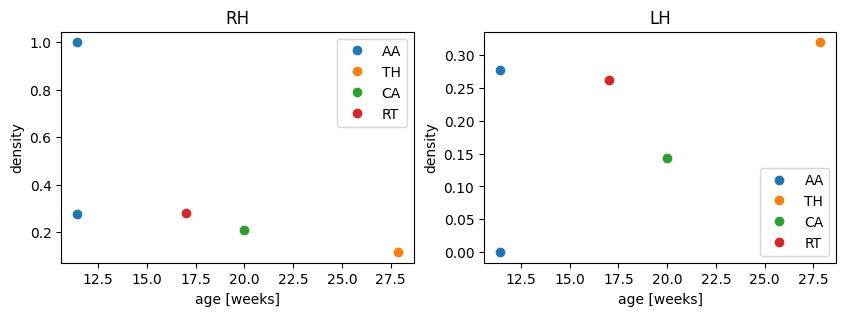

In [12]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 3))

plotting.plot_data_dict(density_RH, filename_dict, "density", ax=ax[0], marker="o", linestyle="none")
ax[0].set_title("RH")

plotting.plot_data_dict(density_LH, filename_dict, "density", ax=ax[1], marker="o", linestyle="none")
ax[1].set_title("LH")

### average data over weeks
With the data structure: `{infant:{week:[recording1, recording2, ..]}}` there may be a case for applying user defined function for all values in week (like average, min, ...). This is provided by `apply_data_dict_function_all_weeks` from `load_data`. The returned variable has structure `{infant:{week:[val]}}`, where `val = f([val1, val2, ..], *args, **kwargs)`. Further functions like `apply_data_dict` can be used.

In this case, we will average density values in weeks.

In [13]:
def average_weeks(recordings_values):
    return sum(recordings_values)/len(recordings_values)

In [14]:
average_density_RH = load_data.apply_data_dict_function_all_weeks(density_RH, average_weeks)
average_density_LH = load_data.apply_data_dict_function_all_weeks(density_LH, average_weeks)

Now we can e.g., join average density for RH and LH and then plot the resulting values as standard error of mean. 
Function `load_data.join_data_dict` will concatenate arrays corresponding to weeks of two variables with dataset structure, e.g.: `{infant:{week:[val1]}} + {infant:{week:[val2]}} = {infant:{week:[val1,val2]}}`.

Text(0.5, 1.0, 'average density for both hands')

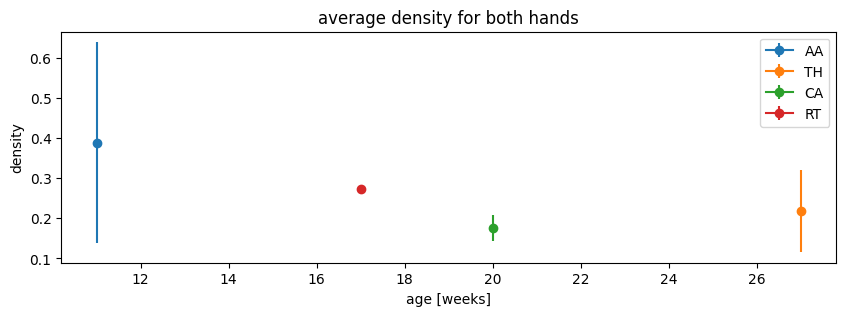

In [15]:
average_density = load_data.join_data_dict(average_density_RH, average_density_LH)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(10, 3))

plotting.plot_data_dict_sem(average_density, "density", ax=ax)
ax.set_title("average density for both hands")
